In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import sparse
from scipy.sparse.linalg import spsolve
import os

In [31]:
def baseline_als(y, lam=1e4, p=0.05, niter=10, reg=1e-9):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L, L - 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose()) + reg * sparse.eye(L)  # Add regularization
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [32]:
def apply_phase_correction(spectrum):
    # Define cost function for phase correction
    def phase_cost(phase, spectrum):
        corrected_spectrum = spectrum * np.exp(1j * phase)
        return np.sum(np.abs(corrected_spectrum.imag))  # Minimize imaginary part

    # Find the optimal phase that minimizes the imaginary component
    result = minimize(phase_cost, 0, args=(spectrum,))
    optimal_phase = result.x[0]

    # Apply phase correction
    spectrum_corrected = spectrum * np.exp(1j * optimal_phase)
    return spectrum_corrected, optimal_phase

In [33]:
def calculate_frequency_shift(spectrum_on, spectrum_off):
    # Define function to calculate the phase shift that minimizes the difference
    def shift_cost(shift, spectrum_on, spectrum_off):
        shifted_spectrum_off = np.roll(spectrum_off, int(shift))
        return np.sum(np.abs(spectrum_on - shifted_spectrum_off))

    # Optimize the shift
    result = minimize(shift_cost, 0, args=(spectrum_on, spectrum_off), bounds=[(-len(spectrum_on) // 2, len(spectrum_on) // 2)])
    optimal_shift = int(result.x[0])

    # Apply the optimal shift to the "off" spectrum
    spectrum_off_corrected = np.roll(spectrum_off, optimal_shift)
    return spectrum_off_corrected, optimal_shift

In [34]:
def my_preprocess(fid_on=None, fid_off=None, do_baseline=True):

    if fid_on is None:
        raise ValueError("fid_on is required")

    if fid_off is None:
        raise ValueError("fid_off is required")

    # Compute the FFT for both signals
    spectrum_on = np.fft.fft(fid_on)
    spectrum_off = np.fft.fft(fid_off)

    # Shift zero frequency to the center for easier visualization and correction
    spectrum_on = np.fft.fftshift(spectrum_on)
    spectrum_off = np.fft.fftshift(spectrum_off)

    # Apply frequency correction
    spectrum_off_corrected, freq_shift = calculate_frequency_shift(spectrum_on, spectrum_off)

    # Apply phase correction on both "on" and "off" spectra
    spectrum_on_corrected, phase_on = apply_phase_correction(spectrum_on)
    spectrum_off_corrected, phase_off = apply_phase_correction(spectrum_off_corrected)

    # Calculate the difference spectrum
    difference_spectrum_corrected = spectrum_on_corrected - spectrum_off_corrected

    if not do_baseline:
        return np.abs(difference_spectrum_corrected)

    # Calculate the baseline using ALS
    baseline = baseline_als(np.abs(difference_spectrum_corrected), lam=1e5, p=0.01, niter=10)

    # Subtract the baseline from the spectrum
    corrected_spectrum = np.abs(difference_spectrum_corrected) - baseline

    return corrected_spectrum



In [35]:
# Parameters
SW = 1200  # Spectral width in Hz
f0 = 123e6  # Resonance frequency in Hz (123 MHz)
delta0 = 4.7  # Reference ppm (water)

# Frequency axis from -SW/2 to SW/2
frequencies = np.linspace(-SW / 2, SW / 2, 512)

# Convert to ppm
ppm = delta0 - (frequencies / f0) * 1e6

In [36]:
subjects_folder = "/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy"

In [37]:
subject_dirs = os.listdir(subjects_folder)
subject_dirs = [subject for subject in subject_dirs if not subject.startswith('.')]
print(f"Found {len(subject_dirs)} subjects")

Found 17 subjects


Working on subject MATHAI
Working on subject PADILLA
Working on subject BOYER


/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation

Working on subject LIN
Working on subject ADLER
Working on subject SHLAIN


/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation

Working on subject MACAULEY
Working on subject JAYANTHI
Working on subject RUNGE
Skipping RUNGE because /Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/RUNGE/SHAM/mrs-svs_task-post does not exist
Working on subject RAMNAUTH


/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation

Working on subject ALLAHABI
Working on subject GHOSH
Working on subject RAHMAN


/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation

Working on subject CABRERA
Working on subject RYAN
Working on subject COACHE


/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_60257/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation

Working on subject AHMED


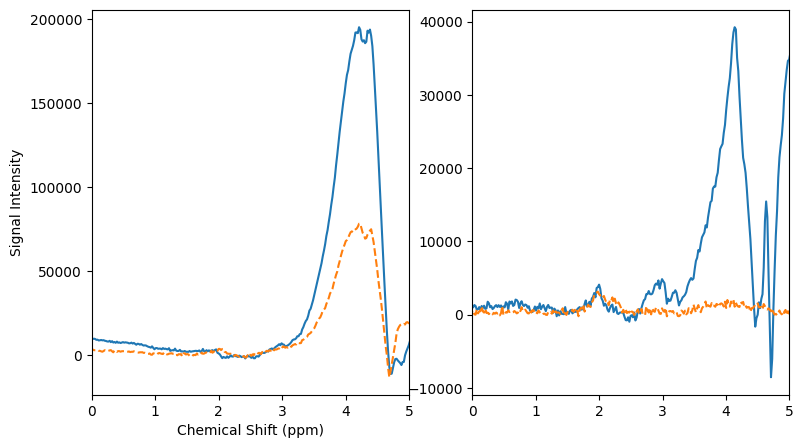

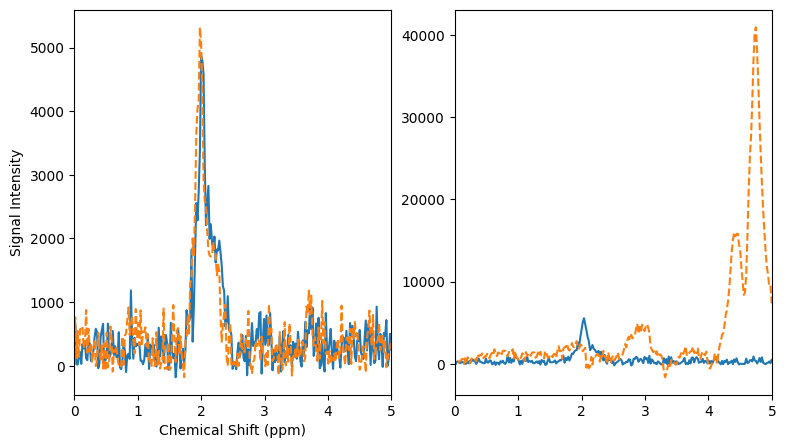

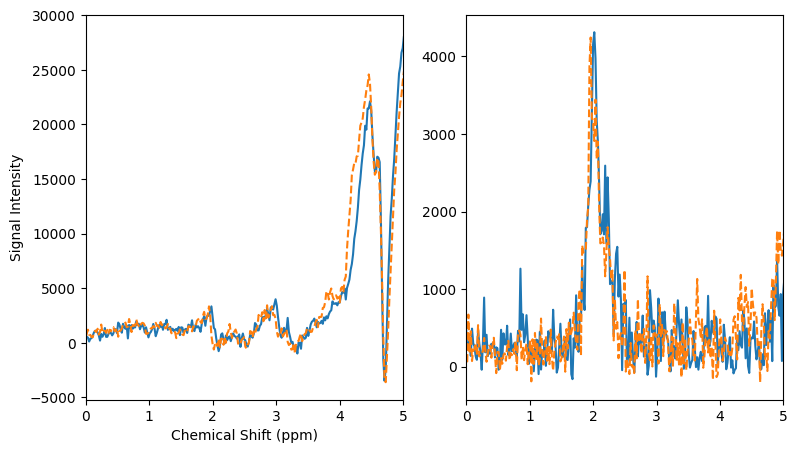

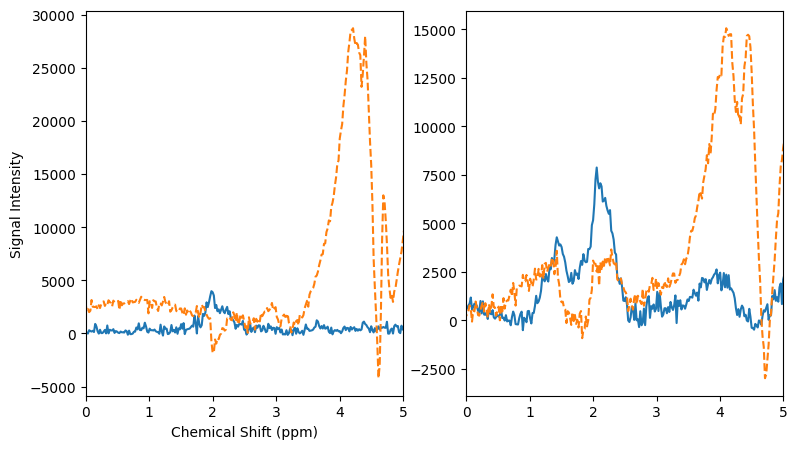

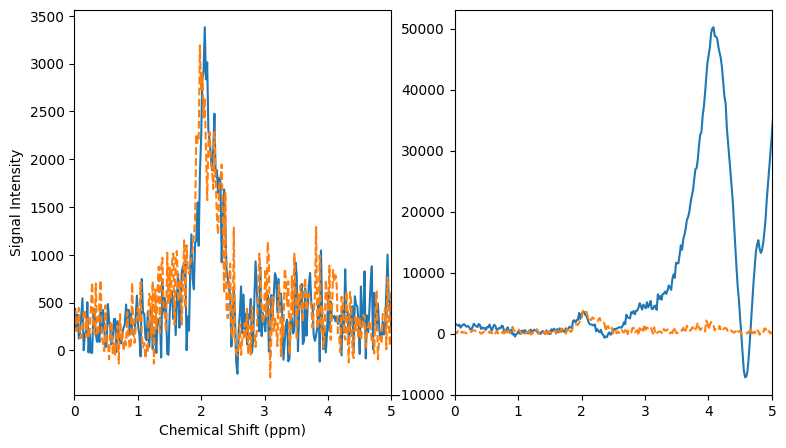

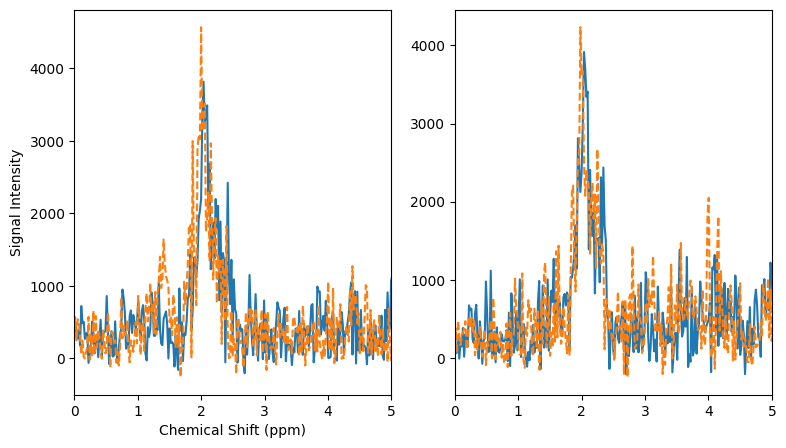

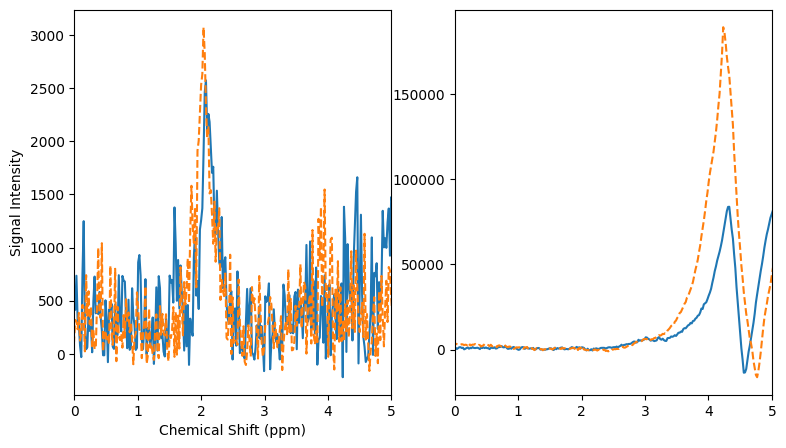

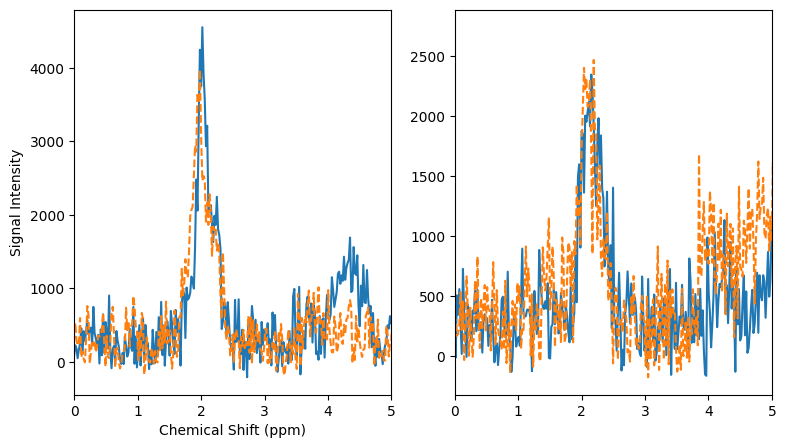

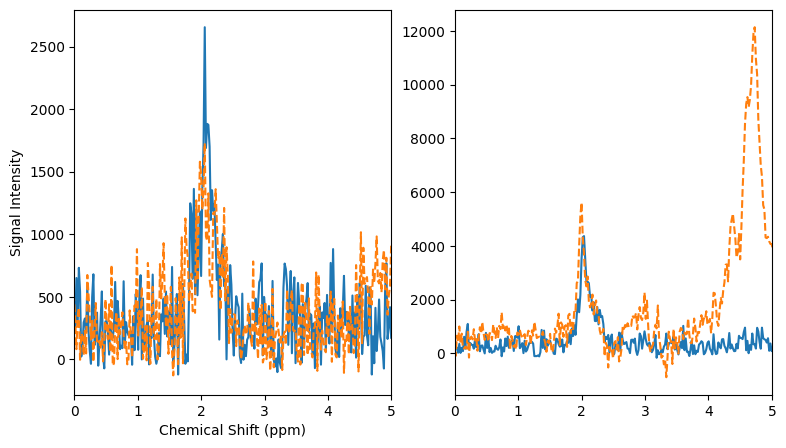

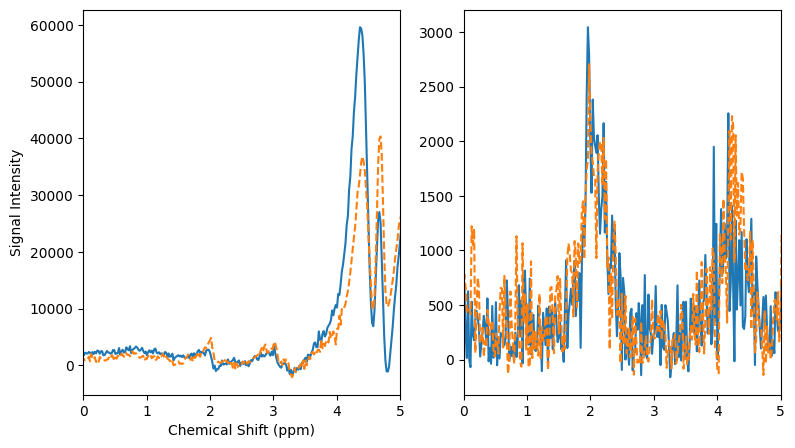

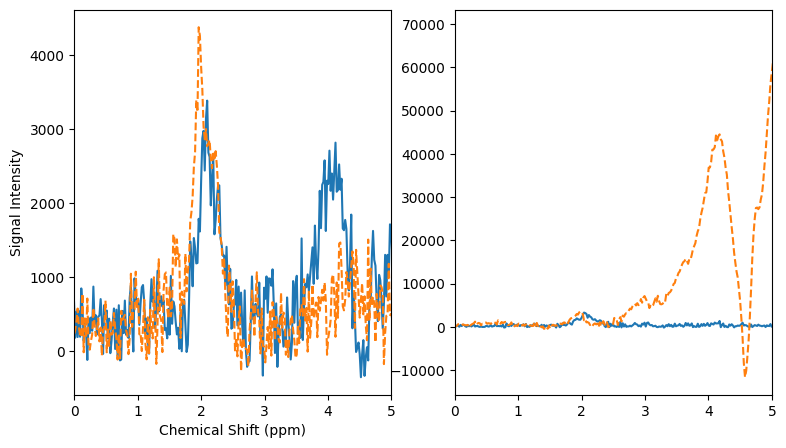

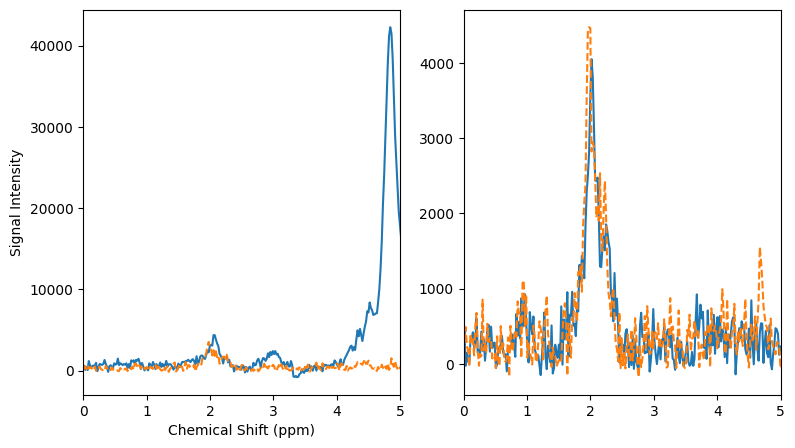

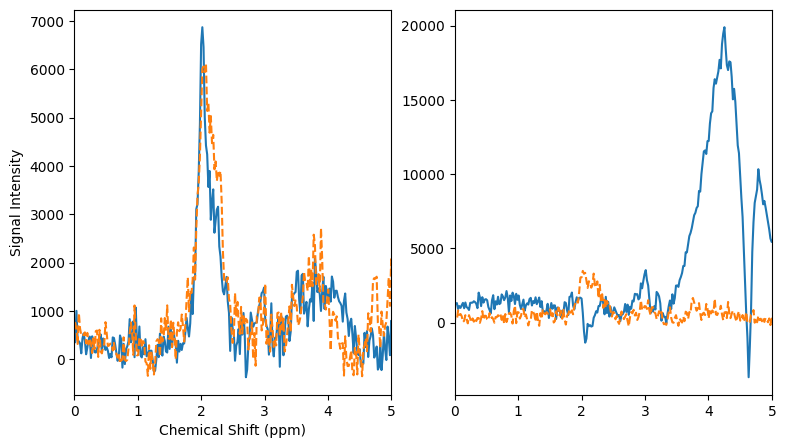

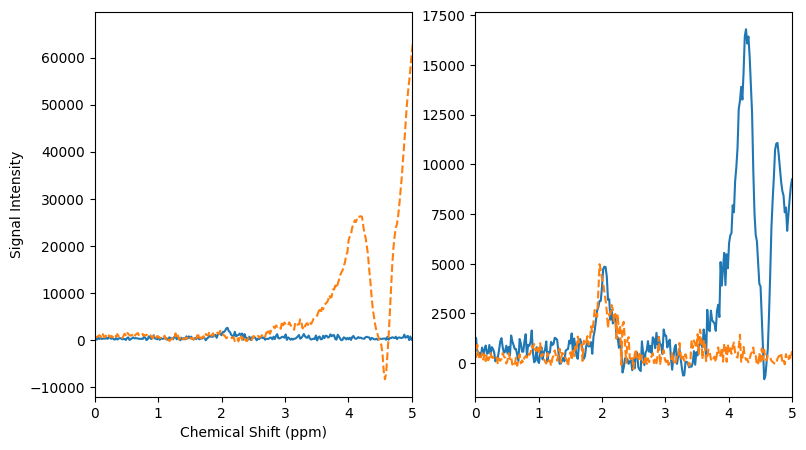

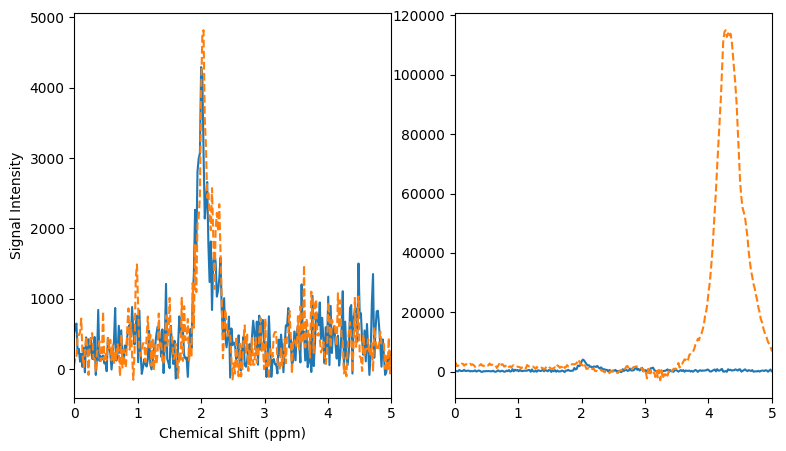

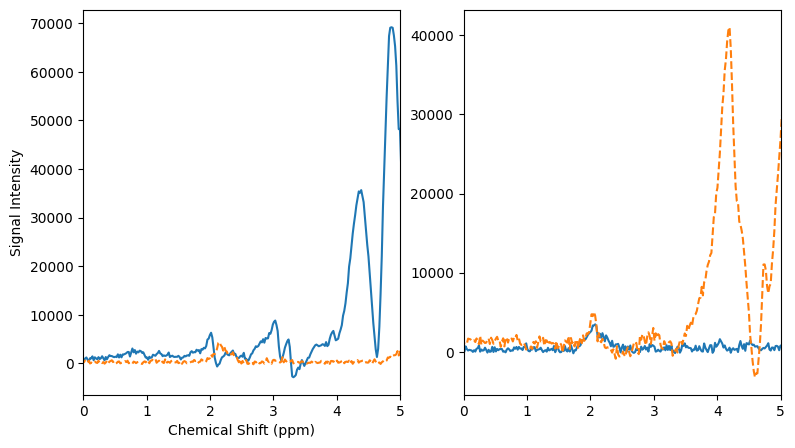

In [38]:
for subject in subject_dirs:

    print(f"Working on subject {subject}")
    path_to_sham_post = f"/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/{subject}/SHAM/mrs-svs_task-post"
    path_to_sham_pre = f"/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/{subject}/SHAM/mrs-svs_task-pre"
    path_to_active_post = f"/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/{subject}/ACTIVE/mrs-svs_task-post"
    path_to_active_pre = f"/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/{subject}/ACTIVE/mrs-svs_task-pre"

    # verify that all four directories exist
    if not os.path.exists(path_to_sham_post):
        print(f"Skipping {subject} because {path_to_sham_post} does not exist")
        continue
    if not os.path.exists(path_to_sham_pre):
        print(f"Skipping {subject} because {path_to_sham_pre} does not exist")
        continue
    if not os.path.exists(path_to_active_post):
        print(f"Skipping {subject} because {path_to_active_post} does not exist")
        continue
    if not os.path.exists(path_to_active_pre):
        print(f"Skipping {subject} because {path_to_active_pre} does not exist")
        continue

    sham_post_file = os.listdir(path_to_sham_post)[0]
    path_to_sham_post = os.path.join(path_to_sham_post, sham_post_file)

    # find nii.gz file in path_to_sham_pre
    sham_pre_file = os.listdir(path_to_sham_pre)[0]
    path_to_sham_pre = os.path.join(path_to_sham_pre, sham_pre_file)

    # find nii.gz file in path_to_active_post
    active_post_file = os.listdir(path_to_active_post)[0]
    path_to_active_post = os.path.join(path_to_active_post, active_post_file)

    # find nii.gz file in path_to_active_pre
    active_pre_file = os.listdir(path_to_active_pre)[0]
    path_to_active_pre = os.path.join(path_to_active_pre, active_pre_file)

    # Load the NIfTI file
    subject_niftis = [path_to_sham_pre, path_to_sham_post, path_to_active_pre, path_to_active_post]
    subject_niftis = [nib.load(nifti).get_fdata(dtype=np.complex64) for nifti in subject_niftis]

    spectra = []
    for nifti_data in subject_niftis:
        fid_on = nifti_data[0, 0, 0, :, 0]  # "on" resonance
        fid_off = nifti_data[0, 0, 0, :, 1]  # "off" resonance
        spectra.append(my_preprocess(fid_on, fid_off, do_baseline=True))

    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    ax[0].plot(ppm, spectra[0], label='Sham Pre')
    ax[0].plot(ppm, spectra[1], label='Sham Post', linestyle='--')
    ax[1].plot(ppm, spectra[2], label='Active Pre')
    ax[1].plot(ppm, spectra[3], label='Active Post', linestyle='--')
    ax[0].set_xlabel("Chemical Shift (ppm)")
    ax[0].set_ylabel("Signal Intensity")
    ax[0].invert_xaxis()
    ax[1].invert_xaxis()
    ax[0].set_xlim(0, 5)
    ax[1].set_xlim(0, 5)

(0.0, 5.0)

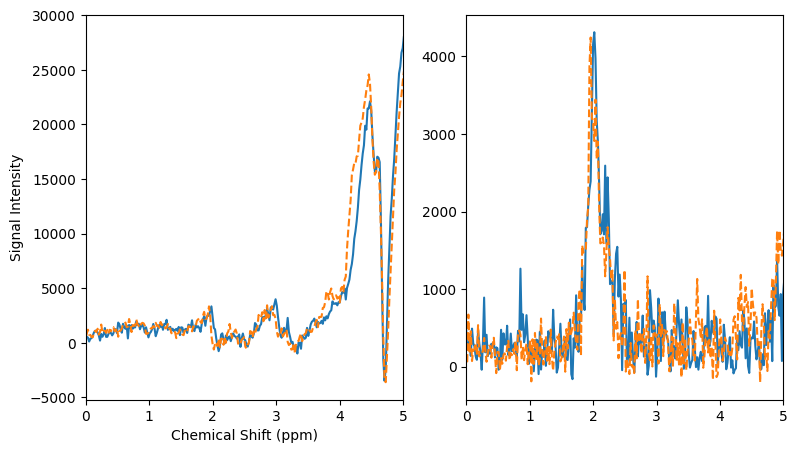

## DEVELOPMENT BELOW

In [23]:
# Compute the FFT for both signals
spectrum_on = np.fft.fft(fid_on)
spectrum_off = np.fft.fft(fid_off)

# Shift zero frequency to the center for easier visualization and correction
spectrum_on = np.fft.fftshift(spectrum_on)
spectrum_off = np.fft.fftshift(spectrum_off)

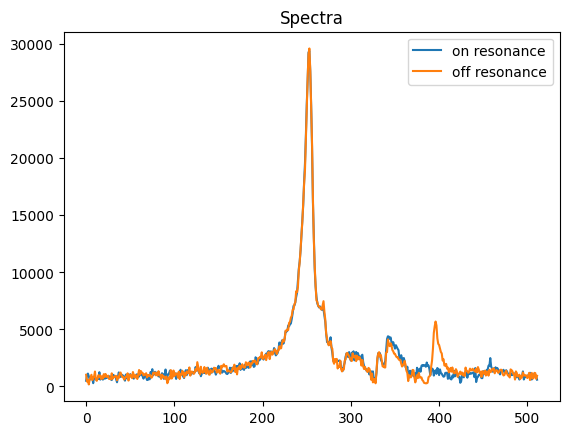

In [24]:
# Plot the spectra
plt.figure()
plt.plot(np.abs(spectrum_on), label="on resonance")
plt.plot(np.abs(spectrum_off), label="off resonance")
plt.legend()
plt.title("Spectra")
plt.show()

In [25]:
# Apply frequency correction
spectrum_off_corrected, freq_shift = calculate_frequency_shift(spectrum_on, spectrum_off)
print(f"Frequency shift applied: {freq_shift}")

Frequency shift applied: 0


/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_59619/3668336855.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_spectrum_off = np.roll(spectrum_off, int(shift))


In [26]:
# Apply phase correction on both "on" and "off" spectra
spectrum_on_corrected, phase_on = apply_phase_correction(spectrum_on)
spectrum_off_corrected, phase_off = apply_phase_correction(spectrum_off_corrected)

print(f"Phase shift applied to on resonance: {phase_on}")
print(f"Phase shift applied to off resonance: {phase_off}")

Phase shift applied to on resonance: 5.082836603059741
Phase shift applied to off resonance: -1.1557529056197358


In [27]:
# Calculate the difference spectrum
difference_spectrum_corrected = spectrum_on_corrected - spectrum_off_corrected

In [28]:
# Calculate the baseline using ALS
baseline = baseline_als(np.abs(difference_spectrum_corrected), lam=1e5, p=0.01, niter=10)

# Subtract the baseline from the spectrum
corrected_spectrum = np.abs(difference_spectrum_corrected) - baseline

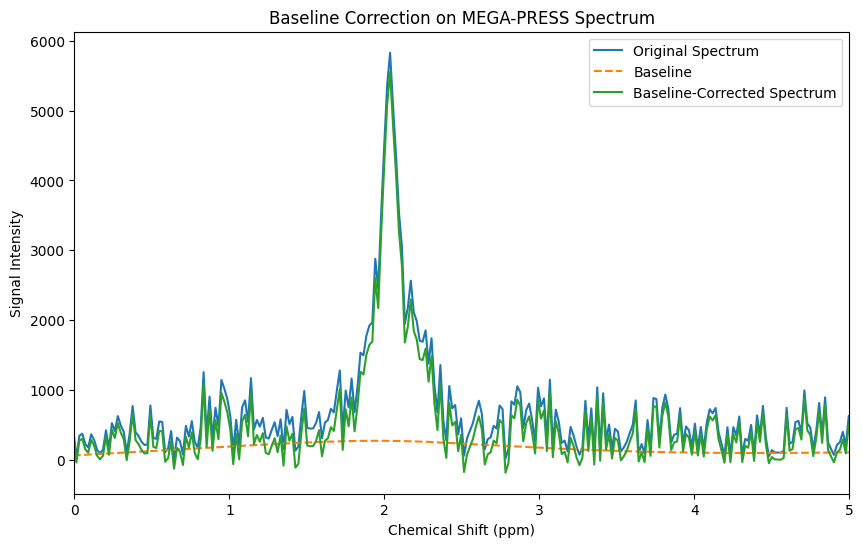

In [30]:
# Frequency axis from -SW/2 to SW/2
frequencies = np.linspace(-SW / 2, SW / 2, 512)

# Convert to ppm
ppm = delta0 - (frequencies / f0) * 1e6

plt.figure(figsize=(10, 6))
plt.plot(ppm, np.abs(difference_spectrum_corrected), label='Original Spectrum')
plt.plot(ppm, baseline, label='Baseline', linestyle='--')
plt.plot(ppm, corrected_spectrum, label='Baseline-Corrected Spectrum')
plt.xlabel("Chemical Shift (ppm)")
plt.ylabel("Signal Intensity")
plt.title("Baseline Correction on MEGA-PRESS Spectrum")
plt.gca().invert_xaxis()  # Invert ppm axis for convention
plt.xlim(0, 5)  # Truncate to 0-5 ppm as before
plt.legend()
plt.show()